In [1]:
import pygplates
import sys
import numpy as np
sys.path.append('../../GPlatesClassStruggle')
sys.path.append('../../passive_margins/')
sys.path.append('../../atom_utils')
sys.path.append('../../platetree')
sys.path.append('../../gwstools')
sys.path.append('../../paleogeography')
sys.path.append('../../')
sys.path.append('../../pyBacktrack')
from raster_reconstruction_classes import *
import matplotlib.pyplot as plt
from reconstruct_atom_rasters import *
import points_spatial_tree
import points_in_polygons
import paleogeography as pg
import tectonic_subsidence as ts 

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use(['dark_background'])

# --- input files
agegrid = GplatesRaster('../data/agegrid_final_mask_0.nc')
topography = GplatesRaster('../data/ETOPO1_0.1.grd')
anomalous_ocean = GplatesRaster('../data/Wessel_lip_seamount_mask.nc')
sediment_thickness = GplatesRaster('../data/sedthick_world_v3_5min_epsg4326_cf.nc')

#rotation_filename = '/Users/Simon/GIT/gplates-web-service/django/GWS/DATA/MODELS/SETON2012/Seton_etal_ESR2012_2012.1.rot'
rotation_filename = '../../agegrid-dev/input_files/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot'

# Note: must be static polygons that have the conjugate plateid assigned
static_polygon_filename = '../../passive_margins/input_data/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2015_v1.shp'



/Users/nickywright/anaconda2/lib/python2.7/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
rotation_model = pygplates.RotationModel(rotation_filename)
static_polygon_features = pygplates.FeatureCollection(static_polygon_filename)

#static_polygon_features = []
#for static_polygon_feature in static_polygon_features_tmp:
#    if static_polygon_feature.get_geometry() is not None:
#        static_polygon_features.append(static_polygon_feature)


In [3]:
# generate a list of lat,lon points with an equal area distribution on the sphere
equal_area_points = PointDistributionOnSphere(distribution_type='healpix',N=64)

points = [point.to_lat_lon_point() for point in equal_area_points.multipoint.get_points()]


In [4]:
# For each point, get the plate id and conjugate plate id from its containing static polygon
# Finally, sample the age grid

spatial_tree_of_uniform_recon_points = points_spatial_tree.PointsSpatialTree(points)

recon_static_polygons = []
recon_static_polygon_plate_ids = []
for static_polygon_feature in static_polygon_features:
    recon_plate_id = static_polygon_feature.get_reconstruction_plate_id()
    recon_conjugate_plate_id = static_polygon_feature.get_conjugate_plate_id()
    recon_polygon = static_polygon_feature.get_geometry()

    recon_static_polygon_plate_ids.append((recon_plate_id,recon_conjugate_plate_id))
    recon_static_polygons.append(recon_polygon)
        
point_plate_pairs = points_in_polygons.find_polygons_using_points_spatial_tree(
    points, spatial_tree_of_uniform_recon_points, recon_static_polygons, recon_static_polygon_plate_ids)


point_ages = agegrid.sample_using_gmt(equal_area_points.longitude,equal_area_points.latitude)



In [5]:
def return_conjugate_points(target_plate_pair):

    points_and_conjugate_points = []
    for point, point_age, plate_ids in zip(points, point_ages, point_plate_pairs):

        if plate_ids is None:
            continue
        elif plate_ids[0] not in target_plate_pair:
            continue
        elif plate_ids[1] not in target_plate_pair:
            continue
        else:
            
            if not np.isnan(point_age):

                finite_rotation = rotation_model.get_rotation(float(point_age), int(plate_ids[0]), 0, int(plate_ids[1]))

                reconstructed_point = finite_rotation * pygplates.PointOnSphere(point)

                points_and_conjugate_points.append([point.to_lat_lon()[1],
                                                    point.to_lat_lon()[0],
                                                    reconstructed_point.to_lat_lon()[1],
                                                    reconstructed_point.to_lat_lon()[0],
                                                    plate_ids[0],
                                                    point_age])
            
    return points_and_conjugate_points


###################
rho_mantle = 3300
rho_water = 1030
phi = 0.56
c = 4.5
#q = 2500

def get_unloaded_bsmt_depth(lons,lats):
    
    point_depth = topography.sample_using_gmt(lons, lats)    
    
    point_sed_thick = sediment_thickness.sample_using_gmt(lons, lats)  
    
    rhoSbar = ts.AverageSedimentDensity(point_sed_thick, phi=phi, c=c)
    
    q = ts.AverageDensityAboveBasement(rhoSbar,point_sed_thick,point_depth)
    
    delta_z = (rho_mantle*point_sed_thick - q) / (rho_mantle - rho_water)
    
    unloaded_bsmt_depth = point_depth - delta_z
    
    return unloaded_bsmt_depth


Get and check the location of the points and conjugate points.
The conjugate points and actual points should plot on top of each other, if we're sampling the grid correctly.

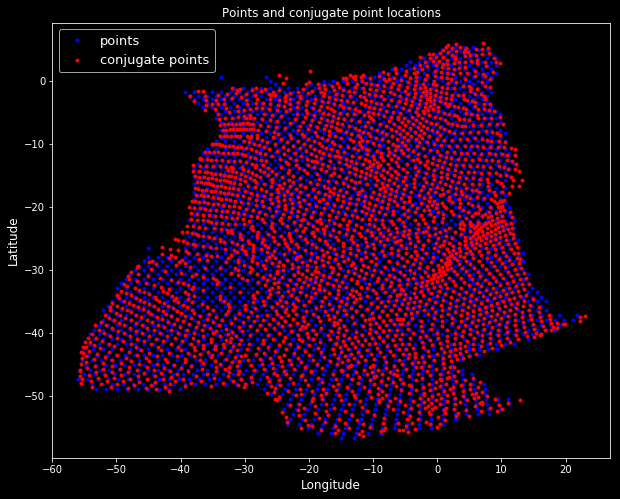

In [20]:
# the returned object is  list of lists, where each list entry contains
# a list for one point, with 6 values
# longitude, latitude, conjugate_longitude, conjugate_latitude, plate_id, seafloor_age

plate_id_1 = 701
plate_id_2 = 201

points_and_conjugate_points = return_conjugate_points([plate_id_1,plate_id_2])

point_longitudes = np.array(zip(*points_and_conjugate_points)[0])
point_latitudes = np.array(zip(*points_and_conjugate_points)[1])
conjugate_longitudes = np.array(zip(*points_and_conjugate_points)[2])
conjugate_latitudes = np.array(zip(*points_and_conjugate_points)[3])
point_plate_ids = np.array(zip(*points_and_conjugate_points)[4])
point_seafloor_ages = np.array(zip(*points_and_conjugate_points)[5])


# this plot checks to see that the points (blue) and their conjugates (rec)
# all plot on top of one another, which they should do for us to be sampling grids
# correctly
fig = plt.figure(figsize=(10,8))
plt.title('Points and conjugate point locations')
plt.plot(point_longitudes,point_latitudes,'b.', label='points')
plt.plot(conjugate_longitudes,conjugate_latitudes,'r.', label='conjugate points')
plt.ylabel("Latitude", fontsize=12)  
plt.xlabel("Longitude", fontsize=12)
plt.legend(fontsize=13)
plt.show()


Compare the depth of the conjugate and actaual points.

The depth of the conjugate points are from the depth of the actual point (reconstucted to its location based on the age of the actual point, and the rotation file).

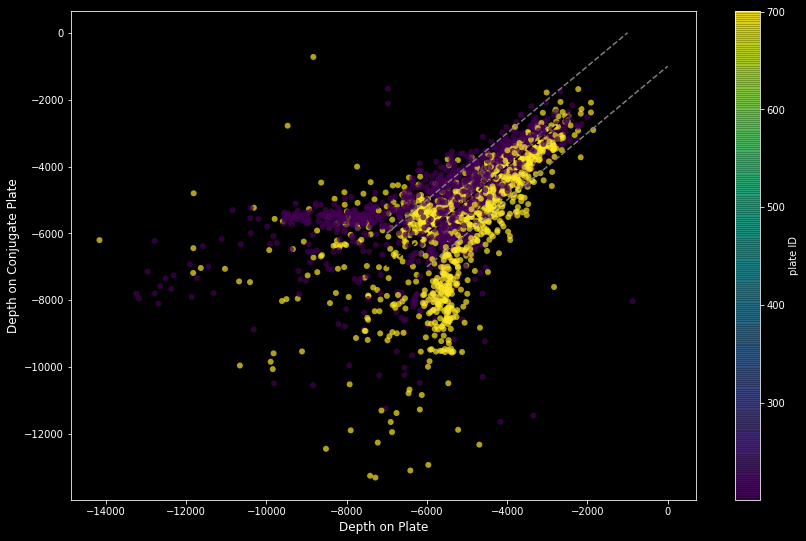

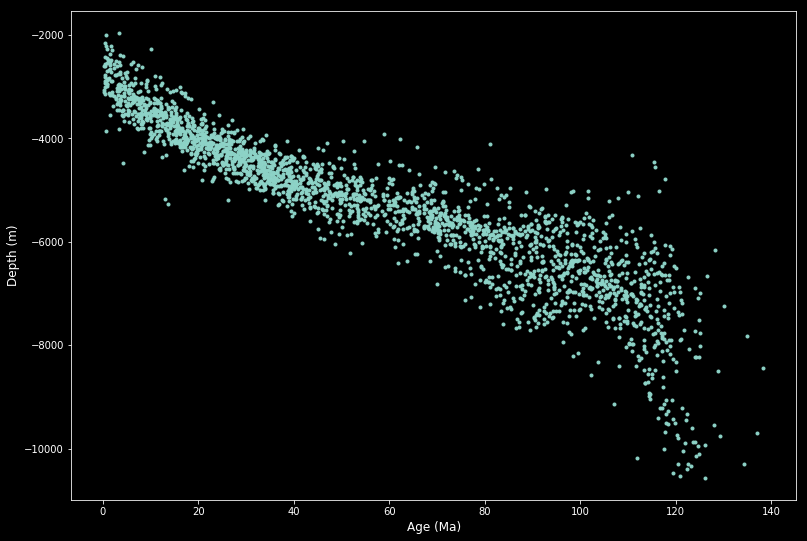

In [30]:
point_depth = get_unloaded_bsmt_depth(point_longitudes,point_latitudes)    
conj_point_depth = get_unloaded_bsmt_depth(conjugate_longitudes,conjugate_latitudes)

point_depth_mask = anomalous_ocean.sample_using_gmt(point_longitudes,point_latitudes)    
conj_point_depth_mask = anomalous_ocean.sample_using_gmt(conjugate_longitudes,conjugate_latitudes)
mask = np.any(np.vstack((point_depth_mask,conj_point_depth_mask)),axis=0)


#print point_depth[mask]
#print zip(*points_and_conjugate_points)[4][mask]

fig = plt.figure(figsize=(14,9))
#plt.plot(point_depth,conj_point_depth,'r.',alpha=0.7)
#plt.plot(point_depth_701,conj_point_depth_701,'b.',alpha=0.7)
plt.scatter(point_depth[~mask],conj_point_depth[~mask],c=point_plate_ids[~mask],edgecolors='',alpha=0.7)
plt.plot([-7000,0],[-7000,0],'k--')
plt.plot([-7000,-1000],[-6000,0],'--',color='gray')
plt.plot([-6000,0],[-7000,-1000],'--',color='gray')
plt.xlabel('Depth on Plate', fontsize=12)
plt.ylabel('Depth on Conjugate Plate', fontsize=12)
# plt.legend(['South America','Africa'])
plt.colorbar(label='plate ID')
plt.show()

fig = plt.figure(figsize=(13,9))
plt.plot(point_seafloor_ages[~mask],np.mean(np.vstack((point_depth,conj_point_depth)),axis=0)[~mask],'.')
plt.xlabel('Age (Ma)', fontsize=12)
plt.ylabel('Depth (m)', fontsize=12)
plt.show()


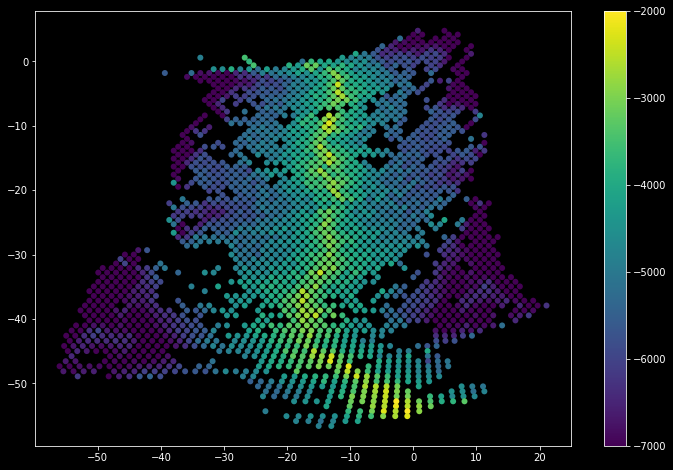

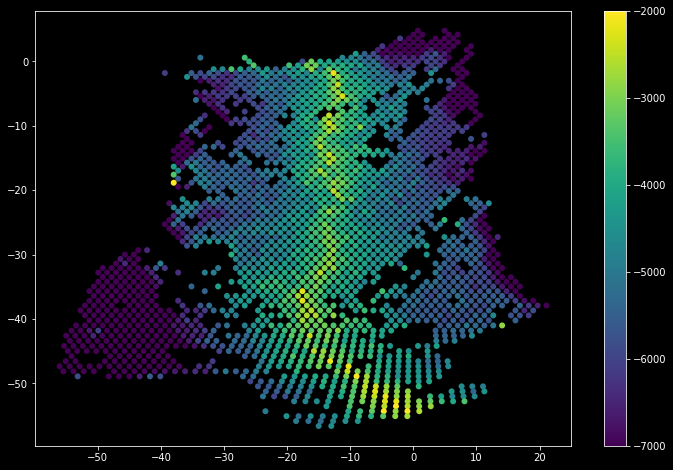

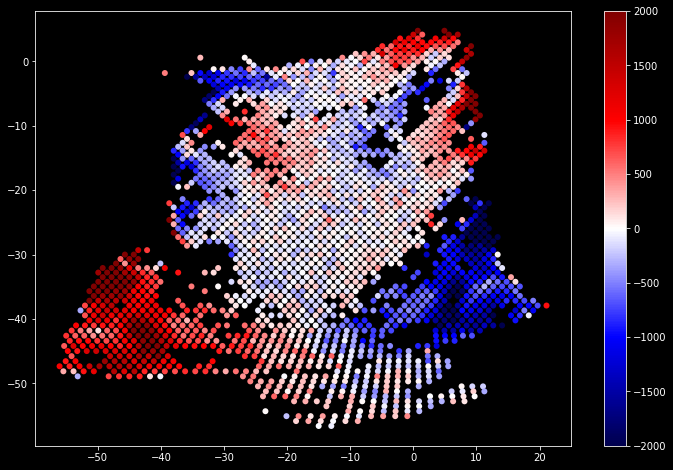

In [8]:
plt.figure(figsize=(12,8))
plt.scatter(point_longitudes[~mask],
            point_latitudes[~mask],
            c=np.mean(np.vstack((point_depth,conj_point_depth)),axis=0)[~mask],
            edgecolors='',vmin=-7000,vmax=-2000)
plt.colorbar()

plt.figure(figsize=(12,8))
plt.scatter(point_longitudes[~mask],
            point_latitudes[~mask],
            c=point_depth[~mask],
            edgecolors='',vmin=-7000,vmax=-2000)
plt.colorbar()

# Asymmetry in present-day depth - the difference between each point and its conjugate
plt.figure(figsize=(12,8))
plt.scatter(point_longitudes[~mask],
            point_latitudes[~mask],
            c=np.mean(np.vstack((point_depth,conj_point_depth)),axis=0)[~mask] - point_depth[~mask],
            edgecolors='',vmin=-2000,vmax=2000,
            cmap=plt.cm.seismic)
plt.colorbar()
                  

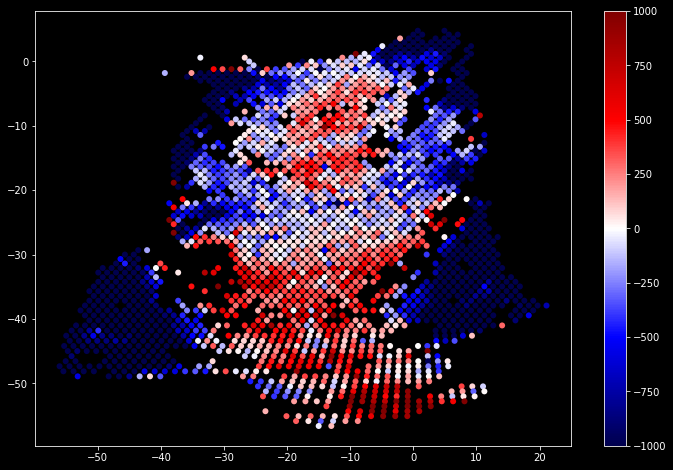

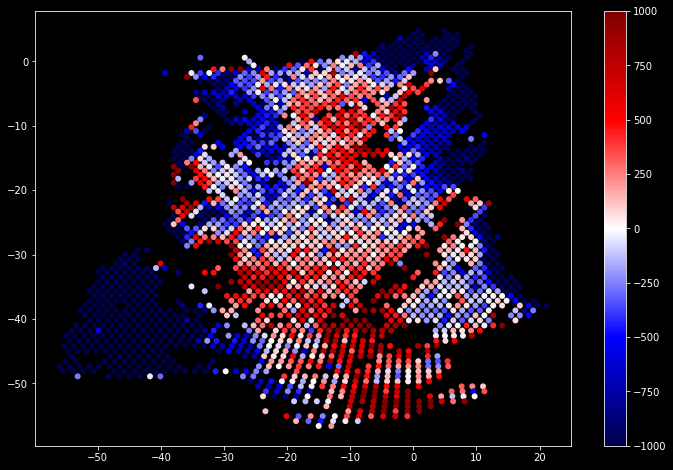

In [9]:
#print zip(*points_and_conjugate_points)[5]#print  
a2d = pg.age2depth(point_seafloor_ages)

asymmetric_residual_basement_depth = point_depth - a2d
symmetric_residual_basement_depth = np.mean(np.vstack((point_depth,conj_point_depth)),axis=0) - a2d

plt.figure(figsize=(12,8))
plt.scatter(point_longitudes[~mask],
            point_latitudes[~mask],
            c=symmetric_residual_basement_depth[~mask],
            edgecolors='',vmin=-1000,vmax=1000,
            cmap=plt.cm.seismic)
plt.colorbar()

plt.figure(figsize=(12,8))
plt.scatter(point_longitudes[~mask],
            point_latitudes[~mask],
            c=asymmetric_residual_basement_depth[~mask],
            edgecolors='',vmin=-1000,vmax=1000,
            cmap=plt.cm.seismic)
plt.colorbar()


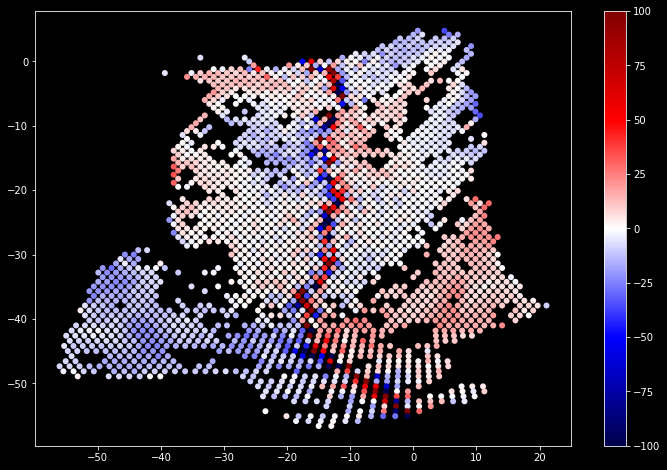

In [10]:
# the term anomalous subsidence is used to describe the different between the expected depth based
# on age depth relationship and the the depth we need will impose to ensure the ocean basin
# always looks symmetric
# We 'know' the anomalous subsidence at two times:
# 1. present-day
# 2. The birth time of the point and its conjugate
# Values in between are derived by linear interpolation

# Example:
# suppose point A lies on 50 Ma crust, and has a residual topography at present-day of +500m
# its conjugate (point B) has a residual topography of +100m
# --> at 50 Ma, we assume the MOR depth was 300 m above 'normal' (which is 2600m?)
# --> assume that the 'anomalous' depth for point A changes linearly from 500m to 300m between 0Ma and 50Ma
# --> 'anomalous' depth for point A changes linearly from 100m to 300m between 0Ma and 50Ma

# --> Rate of anomalous subsidence - positive values mean the residual depth has been increasing through time (greater now than in the past)
anomalous_subsidence_rate = (asymmetric_residual_basement_depth - symmetric_residual_basement_depth) / np.array(zip(*points_and_conjugate_points)[5])

plt.figure(figsize=(12,8))
plt.scatter(point_longitudes[~mask],
            point_latitudes[~mask],
            c=anomalous_subsidence_rate[~mask],
            edgecolors='',vmin=-100,vmax=100,
            cmap=plt.cm.seismic)
plt.colorbar()


../../paleogeography/paleogeography.py:356: RuntimeWarning: invalid value encountered in sqrt
  paleodepth = 2600. + 365. * np.sqrt(age_array)


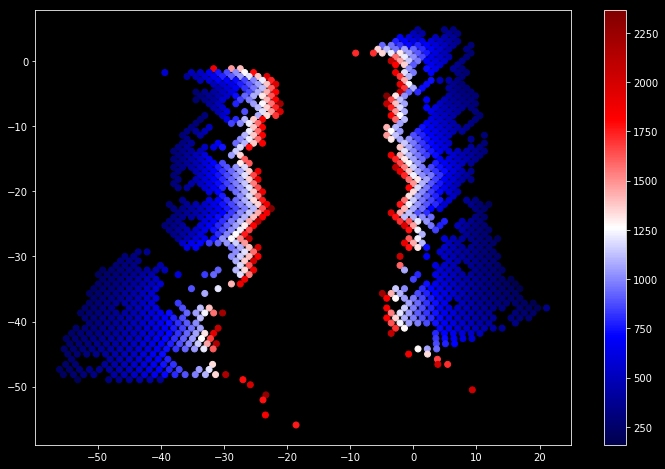

In [11]:
# Choose a time for which to derive backtracked paleotopography
# (Not yet in reconstructed coordinates)
# To figure out the 'expected' subsidence from age depth relationship,
# look at different between the expected depth at present versus reconstruction time
# for each point (since subsidence varies by seafloor age at each point)

recon_time = 50.

# expected depth at present
a2d_present = pg.age2depth(point_seafloor_ages)

# expected depth at reconstruction time
a2d_recon = pg.age2depth(point_seafloor_ages - recon_time)

# expected subsidence between present and reconstruction time
expected_subsidence = a2d_recon - a2d_present

plt.figure(figsize=(12,8))
plt.scatter(point_longitudes[~mask],
            point_latitudes[~mask],
            c=expected_subsidence[~mask],
            cmap=plt.cm.seismic)
plt.colorbar()


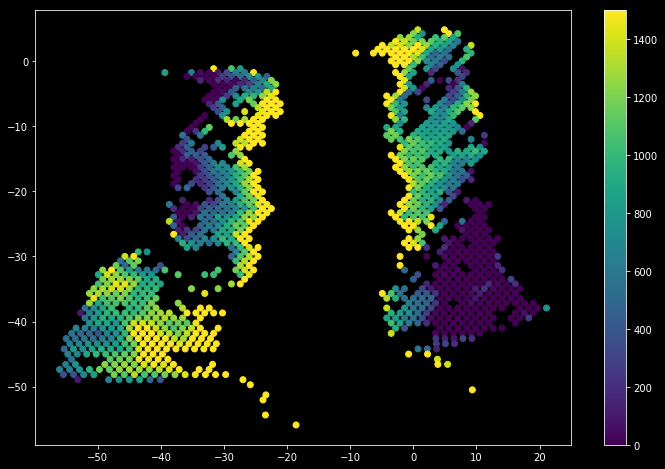

In [12]:
# Derive the total subsidence for each point at the given reconstruction time,
# accounting for both expected and anomalous component

anomalous_subsidence_at_recon_time = anomalous_subsidence_rate * recon_time

total_subsidence = expected_subsidence - anomalous_subsidence_at_recon_time

plt.figure(figsize=(12,8))
plt.scatter(point_longitudes[~mask],
            point_latitudes[~mask],
            c=total_subsidence[~mask],
            vmin=0, vmax=1500)
plt.colorbar()


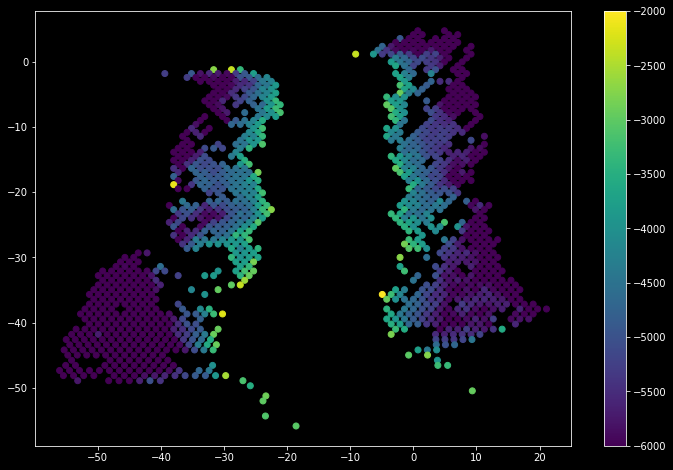

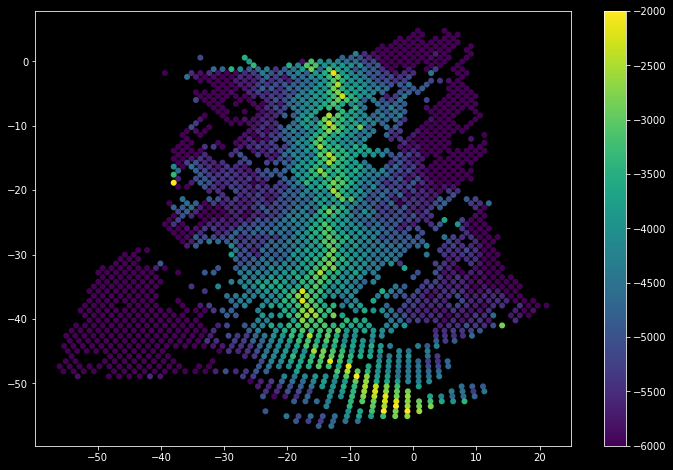

In [13]:
# the backtracked depth is the depth at present day (which is negative), 
# plus the positive value that expresses the combination of expected subsidence 
# (from the age-depth relationship) plus the anomalous subsidence determined from present-day residual topography

backtracked_depth = point_depth + total_subsidence

plt.figure(figsize=(12,8))
plt.scatter(point_longitudes[~mask],
            point_latitudes[~mask],
            c=backtracked_depth[~mask],
            vmin=-6000,vmax=-2000)
plt.colorbar()

plt.figure(figsize=(12,8))
plt.scatter(point_longitudes[~mask],
            point_latitudes[~mask],
            c=point_depth[~mask],
            edgecolors='',vmin=-6000,vmax=-2000)
plt.colorbar()


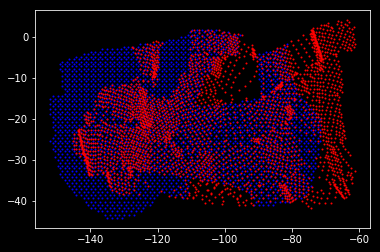

In [14]:
# From here down, trying to look at points with no conjugate


plate_id_1 = 901
plate_id_2 = 911

points_and_conjugate_points = return_conjugate_points([plate_id_1,plate_id_2])

point_longitudes = np.array(zip(*points_and_conjugate_points)[0])
point_latitudes = np.array(zip(*points_and_conjugate_points)[1])
conjugate_longitudes = np.array(zip(*points_and_conjugate_points)[2])
conjugate_latitudes = np.array(zip(*points_and_conjugate_points)[3])
point_plate_ids = np.array(zip(*points_and_conjugate_points)[4])
point_seafloor_ages = np.array(zip(*points_and_conjugate_points)[5])


# this plot checks to see that the points (blue) and their conjugates (rec)
# all plot on top of one another, which they should do for us to be sampling grids
# correctly

plt.plot(point_longitudes,point_latitudes,'b.',markersize=2)
plt.plot(conjugate_longitudes,conjugate_latitudes,'r.',markersize=2)
plt.show()

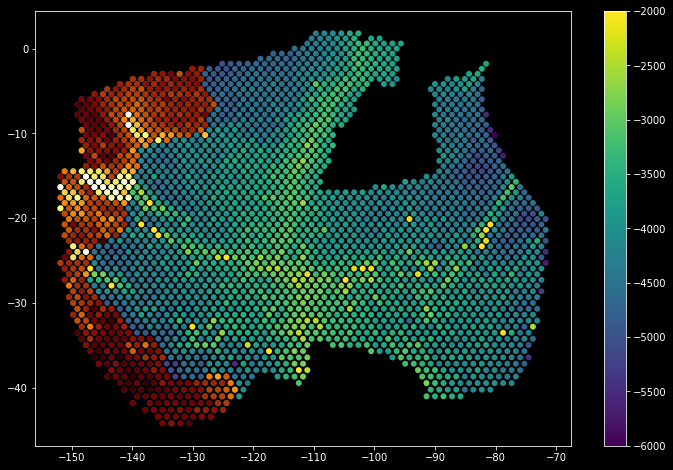

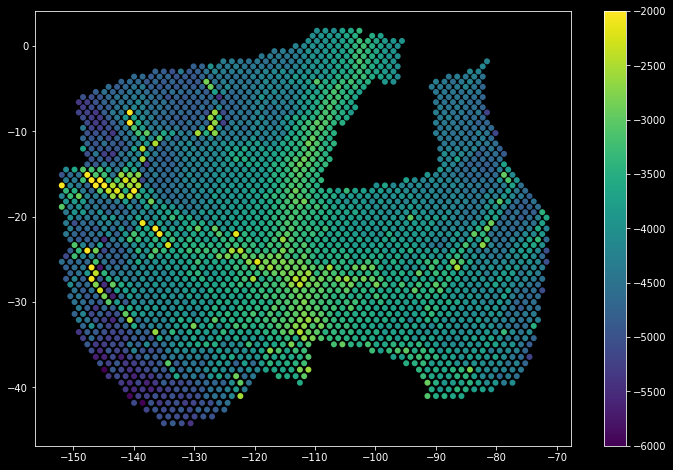

In [15]:
point_depth = get_unloaded_bsmt_depth(point_longitudes,point_latitudes)    
conj_point_depth = get_unloaded_bsmt_depth(conjugate_longitudes,conjugate_latitudes)

point_depth_mask = anomalous_ocean.sample_using_gmt(point_longitudes,point_latitudes)    
conj_point_depth_mask = anomalous_ocean.sample_using_gmt(conjugate_longitudes,conjugate_latitudes)
mask = np.any(np.vstack((point_depth_mask,conj_point_depth_mask)),axis=0)

# this index selects points for which there is crust at 
# present-day, but no preserved conjugate
no_conjugate_index = np.isnan(conj_point_depth)

#print zip(*points_and_conjugate_points)[5]#print  
a2d = pg.age2depth(point_seafloor_ages)

asymmetric_residual_basement_depth = point_depth - a2d
symmetric_residual_basement_depth = np.mean(np.vstack((point_depth,conj_point_depth)),axis=0) - a2d


plt.figure(figsize=(12,8))
plt.scatter(point_longitudes[no_conjugate_index],
            point_latitudes[no_conjugate_index],
            c=point_depth[no_conjugate_index],
            edgecolors='',vmin=-6000,vmax=-2000,
            cmap=plt.cm.afmhot,zorder=3)
#plt.colorbar()

#plt.figure(figsize=(12,8))
plt.scatter(point_longitudes,
            point_latitudes,
            c=point_depth,
            edgecolors='',vmin=-6000,vmax=-2000)
plt.colorbar()

plt.figure(figsize=(12,8))
plt.scatter(point_longitudes[~no_conjugate_index],
            point_latitudes[~no_conjugate_index],
            c=np.mean(np.vstack((point_depth,conj_point_depth)),axis=0)[~no_conjugate_index],
            edgecolors='',vmin=-6000,vmax=-2000)
plt.scatter(point_longitudes[no_conjugate_index],
            point_latitudes[no_conjugate_index],
            c=point_depth[no_conjugate_index],
            edgecolors='',vmin=-6000,vmax=-2000)
plt.colorbar()




In [16]:
zvals = pigsph.interpolateOnSphere(point_longitudes[~no_conjugate_index],
                                   point_latitudes[~no_conjugate_index],
                                   np.mean(np.vstack((point_depth,conj_point_depth)),axis=0)[~no_conjugate_index],
                                   point_longitudes[no_conjugate_index],
                                   point_latitudes[no_conjugate_index],
                                   k=16,n=16)

plt.figure(figsize=(12,8))
plt.scatter(point_longitudes[no_conjugate_index],
            point_latitudes[no_conjugate_index],
            c=zvals,marker='d',
            edgecolors='',s=25,vmin=-6000,vmax=-2000,
            zorder=3)

plt.scatter(point_longitudes[~mask],
            point_latitudes[~mask],
            c=np.mean(np.vstack((point_depth,conj_point_depth)),axis=0)[~mask],
            edgecolors='',s=25,vmin=-6000,vmax=-2000)
plt.colorbar()


AttributeError: 'module' object has no attribute 'interpolateOnSphere'